In [1]:
# 1) Imports & paths
from pathlib import Path
from loguru import logger
from tqdm import tqdm
import sys, os, time
from datetime import timedelta

from pathlib import Path

ADDR_ROOT = Path("/root/LHAI")
ADDR_CODE = ADDR_ROOT / "codes"   # 你的 codes 目录
sys.path.append(str(ADDR_ROOT))
sys.path.append(str(ADDR_CODE))

logger.success(f"ADDR_ROOT set to: {ADDR_ROOT}")
logger.success(f"ADDR_CODE  set to: {ADDR_CODE}")

# 2) Project modules (保证你的项目结构可被 import)
try:
    from codes.config.config_diffusion import EvalConfig
    from codes.function.Dataset import ImageDataset
    import codes.function.Loss as lossfunction
    from codes.function.Log import log
    import codes.function.Train as Train
    from codes.models.DIFFUSION import EnhancedUNetWrapper, Diffusion, positional_encoding, prepare_data
except Exception as e:
    raise ImportError(
        f"❌ 无法导入项目模块：{e}\n"
        f"请确认当前工作目录为项目根目录，或修改上方 ADDR_ROOT/ADDR_CODE。"
    )

# 3) Common libs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import scipy.interpolate

from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure as MS_SSIM
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics.regression import MeanAbsoluteError as MAE

2025-09-09 21:22:58.376 | SUCCESS  | __main__:<module>:15 - ADDR_ROOT set to: /root/LHAI
2025-09-09 21:22:58.378 | SUCCESS  | __main__:<module>:16 - ADDR_CODE  set to: /root/LHAI/codes
2025-09-09 21:22:58.388 | SUCCESS  | codes.config.config_diffusion:<module>:11 - ADDR_CONFIG is: /root/LHAI/codes/config
2025-09-09 21:22:58.390 | INFO     | codes.config.config_diffusion:<module>:12 - ADDR_ROOT is: /root/LHAI
2025-09-09 21:23:01.216 | SUCCESS  | codes.config.config_cnn:<module>:11 - ADDR_CONFIG is: /root/LHAI/codes/config
2025-09-09 21:23:01.218 | INFO     | codes.config.config_cnn:<module>:12 - ADDR_ROOT is: /root/LHAI


In [2]:
# ---- 0. 配置与设备 ----
eval_cfg = EvalConfig()

unet_weight_name = 'unetconfig_DIFFUSION_EXP01_1000epo_32bth_xingwei.pth'
diffusion_weight_name = 'diffusionconfig_DIFFUSION_EXP01_1000epo_32bth_xingwei.pth'

unet_weight_path = f"/root/autodl-tmp/LHAI/saves/MODEL/DDPM/{unet_weight_name}"
diffusion_weight_path = f"/root/autodl-tmp/LHAI/saves/MODEL/DDPM/{diffusion_weight_name}"

# 用传参覆盖默认
exp_name = eval_cfg.exp_name
model_name = eval_cfg.model_name
model_dir =  eval_cfg.model_dir
model_path = eval_cfg.model_path
data_dir = '/root/autodl-fs'
data_name = 'disc_100_64_eval_v2.npy'
data_path = f'{data_dir}/{data_name}'
seed = eval_cfg.seed
frac = eval_cfg.frac
epochs = eval_cfg.epochs
batch_size = eval_cfg.batch_size
lr_max = eval_cfg.lr_max
lr_min = eval_cfg.lr_min
datarange = eval_cfg.datarange
position_encoding_dim = eval_cfg.position_encoding_dim
noise_steps = eval_cfg.noise_steps
logpath = eval_cfg.logpath

torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.success(f"✅ 设备: {device}")

# 创建保存目录
save_root = ADDR_ROOT / "saves" / "EVAL"
save_root.mkdir(parents=True, exist_ok=True)
if logpath is not None:
    Path(logpath).parent.mkdir(parents=True, exist_ok=True)

2025-09-09 21:23:02.347 | SUCCESS  | __main__:<module>:31 - ✅ 设备: cuda:0


In [3]:
# ---- 1. 数据 ----
from torch.utils.data import Subset
# 按顺序划分
filetmp = np.load(data_path,allow_pickle=True)
filelen = filetmp.shape[0]
del filetmp
NUM_TO_LEARN = int(filelen)
dataset = ImageDataset(NUM_TO_LEARN,data_path,inverse=False)
# train_size = int(frac * len(dataset))
# test_size  = len(dataset) - train_size

# train_indices = list(range(0, train_size))
# test_indices  = list(range(train_size, len(dataset)))

# trainset = Subset(dataset, train_indices)
# testset  = Subset(dataset, test_indices)

# trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
testloader  = DataLoader(dataset,  shuffle=True, batch_size=batch_size)

logger.success("✅ 数据加载完成")

2025-09-09 21:23:02.375 | SUCCESS  | __main__:<module>:21 - ✅ 数据加载完成


/tmp/ipykernel_7130/3379978880.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion_config = torch.load(diffusion_weight_path, map_location="cpu")
/tmp/ipykernel_71

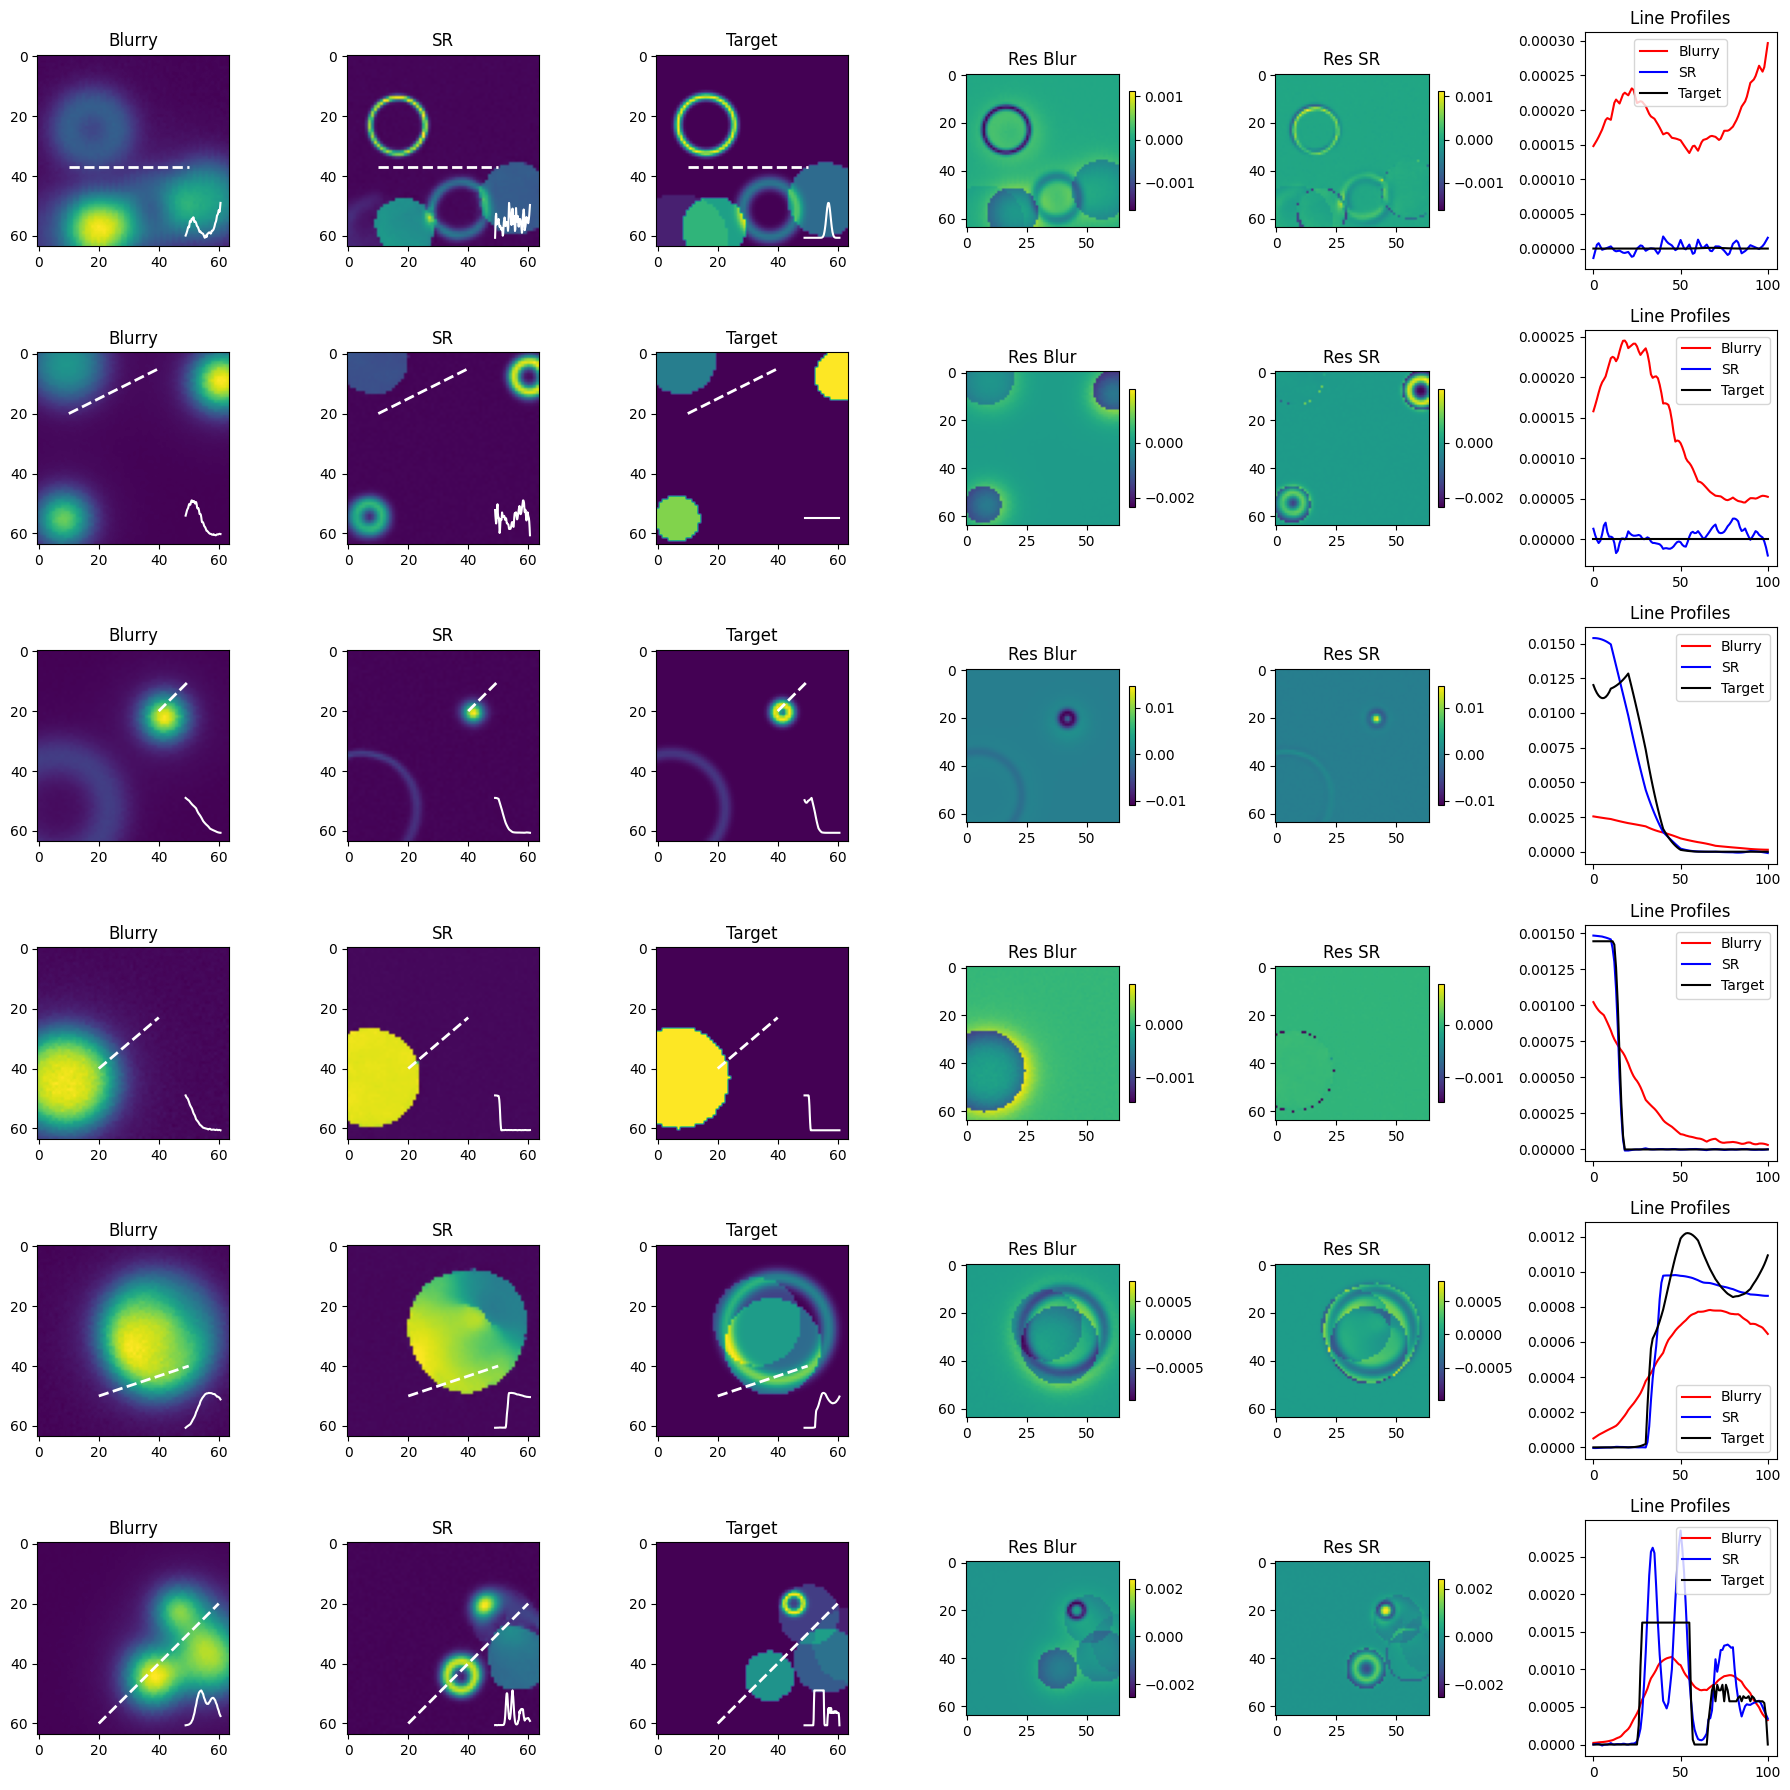

In [4]:
# ---- 2. Diffusion & UNet ----
diffusion_config = torch.load(diffusion_weight_path, map_location="cpu")
diffusion = Diffusion(
    noise_steps=diffusion_config["noise_steps"],
    beta_start=diffusion_config["beta_start"],
    beta_end=diffusion_config["beta_end"],
    img_size=diffusion_config["img_size"],
    device=device
)

# 构建 UNet（默认按你之前的 deeplay.AttentionUNet）
import deeplay as dl
unet = dl.AttentionUNet(
    in_channels=2,
    channels=[32, 64, 128],
    base_channels=[256, 256],
    channel_attention=[False, False, False],
    out_channels=1,
    position_embedding_dim=position_encoding_dim,
)
unet.build()
unet.to(device)
state = torch.load(unet_weight_path, map_location=device)
# 兼容 state_dict / checkpoint
if isinstance(state, dict) and "state_dict" in state:
    state = state["state_dict"]
# 去掉 DataParallel 前缀
clean_state = { (k.replace("module.", "") if k.startswith("module.") else k): v for k, v in state.items() }
missing, unexpected = unet.load_state_dict(clean_state, strict=False)
if missing:
    logger.warning(f"Missing keys when loading UNet: {missing}")
if unexpected:
    logger.warning(f"Unexpected keys when loading UNet: {unexpected}")
unet.eval()

logger.success("✅ 模型加载完成")

# ---- 3. 评估：Line profiles & residual maps ----
def interp2d(x1, x2, y1, y2, arr):
    # 简单二维线性插值（假设正方形图）
    x = np.arange(arr.shape[0])
    y = np.arange(arr.shape[1])
    interp = scipy.interpolate.RegularGridInterpolator((x, y), arr)
    y_t = np.linspace(x1, x2, 101)
    x_t = np.linspace(y1, y2, 101)
    z_t = interp((x_t, y_t))
    return z_t

# 一批测试图像
test_input_images, test_target_images = next(iter(testloader))
test_input_images = test_input_images.to(device)
test_target_images = test_target_images.to(device)

n_images = min(10, test_input_images.shape[0])  # 演示前 n 张

with torch.no_grad():
    generated_images = diffusion.reverse_diffusion(
        model=unet,
        n_images=n_images,
        n_channels=1,
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        input_image=test_input_images[:n_images],
        save_time_steps=[0]
    )

# (T, B, C, H, W) -> (B, T, C, H, W)
generated_images = generated_images.swapaxes(0, 1)

showlist = list(range(min(6, n_images)))
num_images_to_show = len(showlist)
xys = [[10, 50, 37, 37], [10, 40, 20, 5], [40, 50, 20, 10],
       [20, 40, 40, 23], [20, 50, 50, 40], [20, 60, 60, 20]][:num_images_to_show]

img_LR = test_input_images.cpu()
img_HR = test_target_images.cpu()

fig, axes = plt.subplots(num_images_to_show, 6, figsize=(18, 3 * num_images_to_show))

for i in range(num_images_to_show):
    count = showlist[i]
    x1, x2, y1, y2 = xys[i]
    color = "white"

    blurry = img_LR[count].squeeze().numpy()
    target = img_HR[count].squeeze().numpy()

    traj = generated_images[:, count]
    sr = traj[-1].cpu().squeeze().numpy()

    # 归一化（如不需要可移除）
    blurry = blurry / (blurry.sum() + 1e-12)
    sr     = sr     / (sr.sum() + 1e-12)
    target = target / (target.sum() + 1e-12)

    # 0: Blurry
    axes[i, 0].imshow(blurry, cmap="viridis")
    axes[i, 0].set_title("Blurry")
    axes[i, 0].plot([x1, x2], [y1, y2], "--", color=color, linewidth=2)
    axins = inset_axes(axes[i, 0], width="20%", height="20%", loc=4)
    axins.axis("off"); axins.patch.set_alpha(0)
    axins.plot(interp2d(x1, x2, y1, y2, blurry), color=color)

    # 1: SR
    axes[i, 1].imshow(sr, cmap="viridis")
    axes[i, 1].set_title("SR")
    axes[i, 1].plot([x1, x2], [y1, y2], "--", color=color, linewidth=2)
    axins = inset_axes(axes[i, 1], width="20%", height="20%", loc=4)
    axins.axis("off"); axins.patch.set_alpha(0)
    axins.plot(interp2d(x1, x2, y1, y2, sr), color=color)

    # 2: Target
    axes[i, 2].imshow(target, cmap="viridis")
    axes[i, 2].set_title("Target")
    axes[i, 2].plot([x1, x2], [y1, y2], "--", color=color, linewidth=2)
    axins = inset_axes(axes[i, 2], width="20%", height="20%", loc=4)
    axins.axis("off"); axins.patch.set_alpha(0)
    axins.plot(interp2d(x1, x2, y1, y2, target), color=color)

    # 残差图
    res_blur = blurry - target
    res_sr   = sr - target
    vmin = min(res_blur.min(), res_sr.min())
    vmax = max(res_blur.max(), res_sr.max())

    im3 = axes[i, 3].imshow(res_blur, vmin=vmin, vmax=vmax, cmap="viridis")
    axes[i, 3].set_title("Res Blur"); fig.colorbar(im3, ax=axes[i, 3], shrink=0.5)

    im4 = axes[i, 4].imshow(res_sr, vmin=vmin, vmax=vmax, cmap="viridis")
    axes[i, 4].set_title("Res SR"); fig.colorbar(im4, ax=axes[i, 4], shrink=0.5)

    # 线轮廓
    axes[i, 5].plot(interp2d(x1, x2, y1, y2, blurry), color="red",  label="Blurry")
    axes[i, 5].plot(interp2d(x1, x2, y1, y2, sr),     color="blue", label="SR")
    axes[i, 5].plot(interp2d(x1, x2, y1, y2, target), color="black",label="Target")
    axes[i, 5].set_title("Line Profiles"); axes[i, 5].legend()

plt.tight_layout()
savepath = ADDR_ROOT / "saves"
savepath.mkdir(parents=True, exist_ok=True)
(savepath / "EVAL").mkdir(parents=True, exist_ok=True)
savefigname = f"Eval_lineprofiles_{model_name}_{exp_name}"
savefig_path = savepath / "EVAL" / f"{savefigname}.png"
plt.savefig(savefig_path, dpi=300)
logger.success(f"✅ Line profiles saved: {savefig_path}")

In [5]:
# ---- 4. 评估指标 ----
ms_ssim_metric = MS_SSIM(data_range=2.0, kernel_size=7, betas=(0.0448, 0.2856, 0.3001)).to(device)
ssim_metric    = SSIM(data_range=2.0).to(device)
psnr_metric    = PSNR(data_range=2.0).to(device)
mae_metric     = MAE().to(device)

# test_input_images, test_target_images = next(iter(testloader))
# test_input_images = test_input_images.to(device)
# test_target_images = test_target_images.to(device)
all_inputs = []
all_targets = []
for inputs, targets in testloader:
    all_inputs.append(inputs)
    all_targets.append(targets)
test_input_images  = torch.cat(all_inputs, dim=0).to(device)
test_target_images = torch.cat(all_targets, dim=0).to(device)
n_images = 100

with torch.no_grad():
    generated_images = diffusion.reverse_diffusion(
        model=unet,
        n_images=n_images,
        n_channels=1,
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        input_image=test_input_images[:n_images],
        save_time_steps=[0]
    )

generated_images = generated_images.swapaxes(0, 1)

nrmse_list, mae_list, ms_ssim_list, ssim_list, psnr_list = [], [], [], [], []
nrmse_ipt_list, mae_ipt_list, ms_ssim_ipt_list, ssim_ipt_list, psnr_ipt_list = [], [], [], [], []

for i in range(n_images):
    traj = generated_images[:, i]
    gen_img = traj[-1].cpu()
    tgt_img = test_target_images[i].cpu()
    ipt_img = test_input_images[i].cpu()

    mae = torch.mean(torch.abs(gen_img - tgt_img)).item()
    nrmse = torch.sqrt(torch.mean((gen_img - tgt_img) ** 2)) / (tgt_img.max() - tgt_img.min() + 1e-12)
    ms_ssim_val = ms_ssim_metric(gen_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()
    ssim_val    = ssim_metric(gen_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()
    psnr_val    = psnr_metric(gen_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()

    mae_list.append(mae); nrmse_list.append(nrmse.item() if hasattr(nrmse,'item') else float(nrmse))
    ms_ssim_list.append(ms_ssim_val); ssim_list.append(ssim_val); psnr_list.append(psnr_val)

    mae_ipt = torch.mean(torch.abs(ipt_img - tgt_img)).item()
    nrmse_ipt = torch.sqrt(torch.mean((ipt_img - tgt_img) ** 2)) / (tgt_img.max() - tgt_img.min() + 1e-12)
    ms_ssim_ipt_val = ms_ssim_metric(ipt_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()
    ssim_ipt_val    = ssim_metric(ipt_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()
    psnr_ipt_val    = psnr_metric(ipt_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()

    mae_ipt_list.append(mae_ipt)
    nrmse_ipt_list.append(nrmse_ipt.item() if hasattr(nrmse_ipt,'item') else float(nrmse_ipt))
    ms_ssim_ipt_list.append(ms_ssim_ipt_val); ssim_ipt_list.append(ssim_ipt_val); psnr_ipt_list.append(psnr_ipt_val)

print("\n=== Average Metrics on {} Generated Images ===".format(n_images))
print("NRMSE:   {:.6f}".format(np.mean(nrmse_list)))
print("MAE:     {:.6f}".format(np.mean(mae_list)))
print("MS-SSIM: {:.6f}".format(np.mean(ms_ssim_list)))
print("SSIM:    {:.6f}".format(np.mean(ssim_list)))
print("PSNR:    {:.6f}".format(np.mean(psnr_list)))

print("\n=== Average Metrics on {} Input Images ===".format(n_images))
print("NRMSE:   {:.6f}".format(np.mean(nrmse_ipt_list)))
print("MAE:     {:.6f}".format(np.mean(mae_ipt_list)))
print("MS-SSIM: {:.6f}".format(np.mean(ms_ssim_ipt_list)))
print("SSIM:    {:.6f}".format(np.mean(ssim_ipt_list)))
print("PSNR:    {:.6f}".format(np.mean(psnr_ipt_list)))

# ---- 5. 绘图（指标折线） ----
palette = sns.color_palette("Dark2")
image_ids = list(range(1, n_images + 1))

fig, ax = plt.subplots(1, 3, figsize=(19, 5))

# (1) NRMSE & MAE
ax[0].plot(image_ids, mae_list,      color=palette[0], marker='s', label="MAE_gen")
ax[0].plot(image_ids, nrmse_list,    color=palette[1], marker='o', label="NRMSE_gen")
ax[0].plot(image_ids, mae_ipt_list,  color=palette[3], marker='s', label="MAE_ipt")
ax[0].plot(image_ids, nrmse_ipt_list,color=palette[4], marker='o', label="NRMSE_ipt")
ax[0].set_xlabel("Image Index"); ax[0].set_ylabel("Value")
ax[0].set_title("NRMSE & MAE per Image"); ax[0].legend(); ax[0].grid(True)

# (2) MS-SSIM & SSIM
ax[1].plot(image_ids, ms_ssim_list,     color=palette[3], marker='o', label="MS-SSIM_gen")
ax[1].plot(image_ids, ssim_list,        color=palette[4], marker='s', label="SSIM_gen")
ax[1].plot(image_ids, ms_ssim_ipt_list, color=palette[5], marker='o', label="MS-SSIM_ipt")
ax[1].plot(image_ids, ssim_ipt_list,    color=palette[6], marker='s', label="SSIM_ipt")
ax[1].set_xlabel("Image Index"); ax[1].set_ylabel("Value")
ax[1].set_title("MS-SSIM & SSIM per Image"); ax[1].legend(); ax[1].grid(True)
 
# (3) PSNR
ax[2].plot(image_ids, psnr_list,     color=palette[0], marker='o', label="PSNR_gen")
ax[2].plot(image_ids, psnr_ipt_list, color=palette[1], marker='o', label="PSNR_ipt")
ax[2].set_xlabel("Image Index"); ax[2].set_ylabel("Value")
ax[2].set_title("PSNR per Image"); ax[2].legend(); ax[2].grid(True)

plt.tight_layout()
plot_save_path = savepath / "EVAL" / f"evaluationplots_{model_name}_{exp_name}.png"
plt.savefig(plot_save_path, dpi=300)
plt.close()
logger.success(f"✅ Evaluation plots saved: {plot_save_path}")

U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 151.79it/s]



=== Average Metrics on 100 Generated Images ===
NRMSE:   0.078310
MAE:     0.029107
MS-SSIM: 0.958203
SSIM:    0.909554
PSNR:    29.232236

=== Average Metrics on 100 Input Images ===
NRMSE:   0.202591
MAE:     0.139599
MS-SSIM: 0.699260
SSIM:    0.353812
PSNR:    20.531071


2025-09-09 21:23:28.095 | SUCCESS  | __main__:<module>:106 - ✅ Evaluation plots saved: /root/LHAI/saves/EVAL/evaluationplots_DIFFUSION_EXP01.png


In [6]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1) 保存前 3 对图片为 png + npy
# -----------------------------
base_dir = Path("/root/autodl-tmp/LHAI/images_1000eval")
dir_input = base_dir / "input"
dir_target = base_dir / "target"
dir_generated = base_dir / "generated"
for d in [dir_input, dir_target, dir_generated]:
    d.mkdir(parents=True, exist_ok=True)

def _to_2d_numpy(t):
    """(C,H,W) or (1,H,W) -> (H,W) numpy, 不做归一化"""
    arr = t.detach().cpu().numpy()
    return arr.squeeze()

def _save_png(arr2d, path_png, cmap="viridis"):
    """PNG 可视化：按 min-max 归一化到 [0,1]，不改变 .npy 的原始数值"""
    a = arr2d.astype(np.float64)
    vmin, vmax = a.min(), a.max()
    if vmax > vmin:
        a = (a - vmin) / (vmax - vmin)
    else:
        a = np.zeros_like(a)
    plt.imsave(path_png, a, cmap=cmap)

# 生成图像（如果你在上面已经算过 generated_images，就复用）
# generated_images 维度是 (B, T, C, H, W)，取最后一帧：
#   traj = generated_images[:, i] -> (T, C, H, W)
#   traj[-1] -> (C, H, W)

num_to_save = n_images
for idx in range(num_to_save):
    # 取三者 2D 数组
    gen_img_2d = _to_2d_numpy(generated_images[:, idx][-1])   # (H,W)
    tgt_img_2d = _to_2d_numpy(test_target_images[idx])
    ipt_img_2d = _to_2d_numpy(test_input_images[idx])

    # 文件名（1 开始编号）
    i1 = idx + 1
    in_png  = dir_input     / f"input_{i1}.png"
    in_npy  = dir_input     / f"input_{i1}.npy"
    gt_png  = dir_target    / f"target_{i1}.png"
    gt_npy  = dir_target    / f"target_{i1}.npy"
    gen_png = dir_generated / f"generated_{i1}.png"
    gen_npy = dir_generated / f"generated_{i1}.npy"

    # 存 npy（原始数值）
    np.save(in_npy,  ipt_img_2d)
    np.save(gt_npy,  tgt_img_2d)
    np.save(gen_npy, gen_img_2d)

    # 存 png（可视化）
    _save_png(ipt_img_2d, in_png)
    _save_png(tgt_img_2d, gt_png)
    _save_png(gen_img_2d, gen_png)

print(f"✅ Saved first {num_to_save} pairs to:\n  {dir_input}\n  {dir_target}\n  {dir_generated}")

# ----------------------------------------
# 2) 生成 Excel：/root/LHAI/images/eval.xlsx
#    sheet1: input 指标；sheet2: generated 指标
# ----------------------------------------
# 组装 DataFrame（图片编号从 1 开始）
img_ids = np.arange(1, n_images + 1)

df_input = pd.DataFrame({
    "id": img_ids,
    "NRMSE":   np.asarray(nrmse_ipt_list, dtype=np.float64),
    "MAE":     np.asarray(mae_ipt_list, dtype=np.float64),
    "MS-SSIM": np.asarray(ms_ssim_ipt_list, dtype=np.float64),
    "SSIM":    np.asarray(ssim_ipt_list, dtype=np.float64),
    "PSNR":    np.asarray(psnr_ipt_list, dtype=np.float64),
})

df_generated = pd.DataFrame({
    "id": img_ids,
    "NRMSE":   np.asarray(nrmse_list, dtype=np.float64),
    "MAE":     np.asarray(mae_list, dtype=np.float64),
    "MS-SSIM": np.asarray(ms_ssim_list, dtype=np.float64),
    "SSIM":    np.asarray(ssim_list, dtype=np.float64),
    "PSNR":    np.asarray(psnr_list, dtype=np.float64),
})

excel_path = base_dir / "eval.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    df_input.to_excel(writer, sheet_name="input", index=False)
    df_generated.to_excel(writer, sheet_name="generated", index=False)

print(f"✅ Excel saved: {excel_path}")


✅ Saved first 100 pairs to:
  /root/autodl-tmp/LHAI/images_1000eval/input
  /root/autodl-tmp/LHAI/images_1000eval/target
  /root/autodl-tmp/LHAI/images_1000eval/generated
✅ Excel saved: /root/autodl-tmp/LHAI/images_1000eval/eval.xlsx
